In [1]:
import silence_tensorflow.auto
import tensorflow as tf

# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()


import keras
import random

gpuDevices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpuDevices))
tf.config.experimental.set_memory_growth(gpuDevices[0], True)
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})

Num GPUs Available:  1


I0000 00:00:1724524155.252766  345144 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724524155.397790  345144 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724524155.401419  345144 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
import PIL
import glob
import torchshow as ts
import random
import time
# import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split


In [3]:
tf.random.set_seed(42)
keras.backend.clear_session()

In [4]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()

train_images = tf.image.convert_image_dtype(train_images, dtype=tf.float32)
test_images = tf.image.convert_image_dtype(test_images, dtype=tf.float32)


train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
print(train_images.shape)

(60000, 28, 28, 1)


I0000 00:00:1724524157.002083  345144 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724524157.006170  345144 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724524157.009504  345144 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724524157.167791  345144 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
def plot_n_samples(dataset, n ):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(tf.squeeze(dataset[i]).numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
import gc
gc.collect()

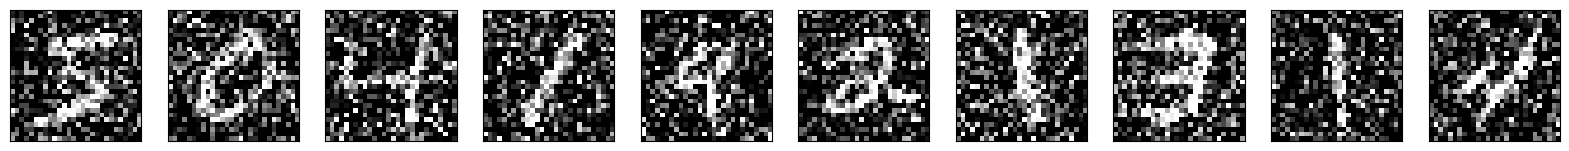

In [6]:
noise_factor = 0.5

train_images_noisy = train_images + noise_factor * tf.random.normal(shape=train_images.shape)
test_images_noisy = test_images + noise_factor * tf.random.normal(shape=test_images.shape)

train_images_noisy = tf.clip_by_value(train_images_noisy, clip_value_min=0., clip_value_max=1.)
test_images_noisy = tf.clip_by_value(test_images_noisy, clip_value_min=0., clip_value_max=1.)

plot_n_samples(train_images_noisy, 10)

In [7]:
def make_encoder() :
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28, 1)))

    
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
    assert model.output_shape == (None, 14,14,16)
    
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
    assert model.output_shape == (None, 7,7,8)

    return model

In [8]:
def make_decoder():
    model = keras.Sequential()
    # model.add(keras.layers.Input(shape = (7,7,8)))
    model.add(keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'))
    # assert model.input_shape == (None, 7,7,8)
    
    # assert model.output_shape == (None, 14,14,8)

    model.add(keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    
    # assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [9]:
class Denoise(keras.Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = make_encoder()
        self.decoder = make_decoder()

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
epochs = 10
batch_size = 32
lr = 0.0002

In [11]:
autoencoder = Denoise()
optimizer = keras.optimizers.Adam(learning_rate=lr) 
loss_fn = keras.losses.MeanSquaredError()


train_dataset = tf.data.Dataset.from_tensor_slices((train_images_noisy, train_images))
train_dataset = train_dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((test_images_noisy, test_images))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [12]:
@tf.function
def train_step(batch_noisy: tf.Tensor, batch_clean: tf.Tensor) -> tf.Tensor:
    with tf.GradientTape() as tape:
        predictions = autoencoder(batch_noisy, training=True)
        loss = loss_fn(batch_clean, predictions)
    grads = tape.gradient(loss, autoencoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, autoencoder.trainable_variables))
    return loss

# Define the validation step function with @tf.function
@tf.function
def val_step(val_noisy: tf.Tensor, val_clean: tf.Tensor) -> tf.Tensor:
    val_predictions = autoencoder(val_noisy, training=False)
    return loss_fn(val_clean, val_predictions)

In [13]:
for epoch in range(epochs):
    start_time = time.process_time()
    
    print(f"Epoch {epoch+1}/{epochs}")
    
    train_loss= None
    # Training
    for batch_noisy, batch_clean in train_dataset:
        train_loss = train_step(batch_noisy, batch_clean)

    
    # # Validation
    # val_loss = 0
    # num_batches = 0
    # for val_noisy, val_clean in val_dataset:
    #     # Ensure tensors are used
    #     val_loss += val_step(val_noisy, val_clean).numpy()
    #     num_batches += 1
    # val_loss /= num_batches
    if(train_loss):
        print(f"Training loss: {train_loss.numpy():.4f}")
    
    end_time = time.process_time()
    epoch_duration = end_time - start_time
    # print(f"Validation loss: {val_loss:.4f}")
    print(f"Time for epoch {epoch+1}: {epoch_duration:.2f} seconds")

Training loss: 0.0253
Time for epoch 1: 11.60 seconds
Epoch 2/10
Training loss: 0.0148
Time for epoch 2: 7.49 seconds
Epoch 3/10
Training loss: 0.0141
Time for epoch 3: 7.24 seconds
Epoch 4/10
Training loss: 0.0149
Time for epoch 4: 7.56 seconds
Epoch 5/10
Training loss: 0.0146
Time for epoch 5: 8.56 seconds
Epoch 6/10
Training loss: 0.0142
Time for epoch 6: 7.45 seconds
Epoch 7/10
Training loss: 0.0144
Time for epoch 7: 7.34 seconds
Epoch 8/10
Training loss: 0.0144
Time for epoch 8: 7.62 seconds
Epoch 9/10
Training loss: 0.0156
Time for epoch 9: 7.62 seconds
Epoch 10/10
Training loss: 0.0129
Time for epoch 10: 7.26 seconds


In [ ]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        print((epoch,time.process_time() - self.timetaken))
        self.timetaken = time.process_time()

In [ ]:
timetaken = timecallback()
autoencoder = Denoise()
autoencoder.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError)
autoencoder.fit(train_images_noisy, train_images,
                epochs=10,
                shuffle=True,
                validation_data=(test_images_noisy, test_images),callbacks = [timetaken])

In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

In [ ]:
encoded_imgs = autoencoder.encoder(test_images_noisy[:10]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs[:10]).numpy()

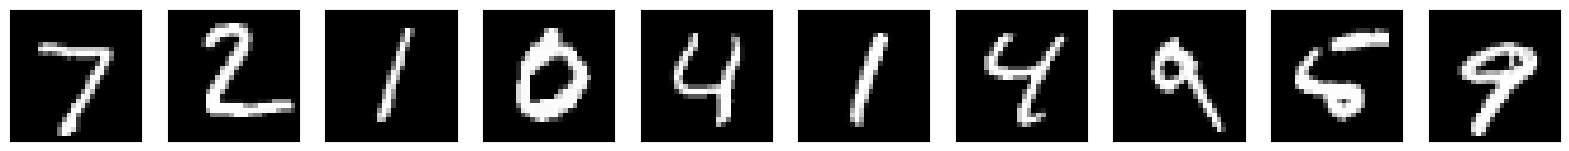

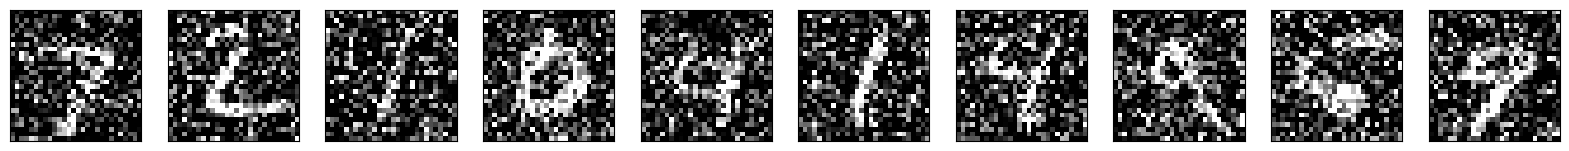

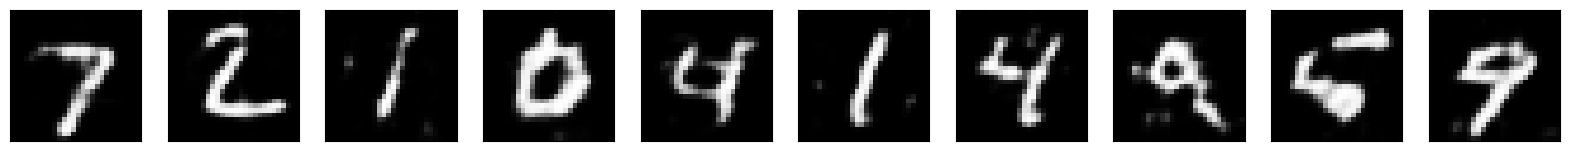

In [15]:
plot_n_samples(test_images, 10)
plot_n_samples(test_images_noisy, 10)
plot_n_samples(decoded_imgs, 10)
